In [ ]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import numpy as np
from collections import defaultdict
from google.colab import files
import math

# set parameters
random.seed(249469394)
N_POP = 10000  # no. of population
N_SICK = 10  # no. of sick
DAYS_INCUB = 2 + 1  # days of incubation (add 1 b/c counter starts at 1)
SICK_SPELL = [7,9]  # length of infection (mode and median of lognormal)
SOCIAL = [[8,10], [4,5], [1,2]]  # number of social interactions w/o and w/ social distancing (mode and median of lognormals)
PROBS = [0.6,0.3,0.2,0.1]  # probabilities of infection when meeting sick
PROB_DEATH = 0.03  # probability of dying when infected
VAX_BETWEEN = 15  # days between 1st and 2nd injection
VAX_LAG = 10  # days between injection and immunity


def logN(mode_med: list) -> int:
  """
  Samples from a lognormal and floors.

  :param mode: mode of lognormal distribution
  :param median: median of lognormal distribution
  :return: floored lognormal(mu, sigma) observation
  """
  mode, median = mode_med
  assert mode < median, "Mode might not be greater than the median. Set the parameters accordingly."

  mu = math.log(median)  # mu parameter
  sigma = math.sqrt(mu-math.log(mode))  # sigma parameter
  return math.floor(np.random.lognormal(mu, sigma))


def initialize_population(n: int, n_sick: int) -> dict:
  """
  Initializes a population.

  :param n: number of individuals
  :param n__: number of sick individuals
  :return: dictionary with individual features
  """

  # infection
  id = ['id_' + str(i) for i in range(n)]  # IDs
  sick = [1 for i in range(n_sick)] + [0 for i in range(n-n_sick)]  # status {'healthy': 0, , 'sick': 1, 'recovered': 2, 'dead': 3}
  sick_counter = [DAYS_INCUB + 1 for i in range(n_sick)] + [0 for i in range(n-n_sick)]  # days from infection 
  dead = [0 for i in range(n)]  # dead dummy
  sick_spell = [logN(SICK_SPELL) for i in range(n_sick)] + [0 for i in range(n-n_sick)]  # length of infection

  # vaccine
  vax = [0 for i in range(n)]  # vaccine {'no': 0, '1st dose': 1, '2nd dose': 2}
  vax1_counter = [0 for i in range(n)]  # days from 1st dose
  vax2_counter = [0 for i in range(n)]  # days from 2nd dose

  # policies
  mask = [0 for i in range(n)]  # masking dummy
  socdist = [0 for i in range(n)]  # social distancing dummy

  keys = ['id', 'sick', 'sick_counter', 'sick_spell', 'vax', 'vax1_counter', 'vax2_counter', 'dead', 'mask', 'socdist']
  
  return {k:v for k,v in locals().items() if k in keys}


def count_sick(sick: list) -> int:
  """
  Counts number of sick individuals.
  """
  return int(len([i for i in sick if i == 1]))


def subset_population(pop: dict):
  """
  Returns lists of indexes for the different health status.
  """

  idx_healthy, idx_incubation, idx_recovered, idx_dead, idx_sick = [], [], [], [], []

  # extract features
  ids = [i for i in range(len(pop['id']))]
  statuses = [s for s in pop['sick']]
  counters = [c for c in pop['sick_counter']]

  # subset
  for idx, status, counter in zip(ids, statuses, counters):
    if (status == 0): idx_healthy.append(idx)
    elif (status == 1) and (counter <=DAYS_INCUB): idx_incubation.append(idx)
    elif (status == 2): idx_recovered.append(idx)
    elif (status == 3): idx_dead.append(idx)
    else: idx_sick.append(idx)

  return idx_healthy, idx_incubation, idx_recovered, idx_dead, idx_sick


def calculate_conditional(pop: dict, idx: int) -> float:
  """
  Returns the conditional probability of an infection given a contact with a carrier.

  :param pop: dictionary holding population
  :param idx: individual index
  :return: probability of infection
  """

  # extract individual features
  status = [pop['mask'][idx],  # masking
            pop['vax'][idx],  # vaccine dummy
            pop['vax1_counter'][idx] > VAX_LAG,  # more than 10 days from 1st vaccine
            pop['vax2_counter'][idx] > VAX_LAG]  # more than 10 days from 1st vaccine

  # calculate probability
  if status == ([1,0,0,0] or [1,1,0,0]):  p = PROBS[1] # masking
  elif status == ([1,1,1,0] or [0,1,1,0]):  p = PROBS[2] # vaccine 1st dose
  elif status == ([1,2,1,0] or [0,2,1,0]):  p = PROBS[2] # vaccine 2nd dose (not yet immune)
  elif status == ([0,2,1,1] or [1,2,1,1]):  p = PROBS[3] # vaccine 2nd dose
  else: p = PROBS[0]
  return p


def day_report(sick__: list, sick: list) -> list:
  """
  Returns a summary of new cases, deaths, and recovered patients.

  :param pop__: population at prior time-period
  :param pop: population at current time-period
  :return: list holding summary stats 
  """
  cases, recovered, deaths = 0,0,0

  # for each individual
  for before, after in zip(sick__, sick):
    # if before-after statuses differ
    if before != after:
      if after == 3: deaths += 1
      if after == 2: recovered += 1
      if after == 1: cases += 1
  return [cases, recovered, deaths]


def update_population(pop: dict, masking: int, socdist: int) -> dict:
  """
  Updates the population for the next time-period.

  :param pop: population
  :param p_death: probability of death conditional on infection
  :param masking: mask-wearing dummy
  :param socdist: social distancing dummy
  :return: updated population
  """

  # containment policies
  for idx in range(len(pop['id'])):
    pop['mask'][idx] = 1 if masking else 0
    if socdist == 0:
      pop['socdist'][idx] = 0
    elif socdist == 1:
      pop['socdist'][idx] = 1
    else:
      pop['socdist'][idx] = 2
  
  # subset population
  idx_healthy, idx_incubation, idx_recovered, idx_dead, idx_sick = subset_population(pop)
  
  # calculate probabilities
  p1 = len(idx_incubation + idx_sick)/len(idx_healthy + idx_recovered + idx_incubation + idx_sick)  # P(meeting someone sick)
  p3 = PROB_DEATH  # P(death | infection)

  # update healthy

  # for each individual
  for idx in idx_healthy:

    # number of social interactions depends on social distancing
    if pop['socdist'][idx] == 0:
      social = logN(SOCIAL[0])
    elif pop['socdist'][idx] == 1:
      social = logN(SOCIAL[1])
    else:
      social = logN(SOCIAL[2])
    # for each interaction, Bernoulli(p) trials with prob p1 of meeting someone sick
    s = 0
    while s < social:
      s += 1
      # if meets someone sick
      if random.random() <= p1:
        # if gets infected
        p2 = calculate_conditional(pop, idx)  # P(infection | meeting someone sick)
        if random.random() <= p2:
          pop['sick'][idx] += 1  # update status to sick
          pop['sick_counter'][idx] += 1  # update counter
          pop['sick_spell'][idx] == logN(SICK_SPELL)  # assign length of infection
          if random.random() <= p3: # assign fatality with prob p3
            pop['dead'][idx] == 1
            pop["sick"][idx] += 2
          else:
            0

          # stop Bernoulli trials if gets infected
          break


  # update sick

  # for each individual
  for idx in idx_sick + idx_incubation:
    pop['sick_counter'][idx] += 1

    # if last day of infection
    if pop['sick_counter'][idx] == (pop['sick_spell'][idx] + DAYS_INCUB + 1):
      # recovers
      pop['sick'][idx] += 1
  
  return pop


def vaccine_update(pop: dict, vax_n: int, vax_strat = 0)  -> dict:
  """
  Updates the vaccine rollout.
  Two rollout strategies are possible, maximizing first dose injections or second dose injections.

  :param pop: population
  :param vax_n: number of vaccines / day
  :param days_between: days between 1st and 2nd dose
  :param vax_strat strategy dummy (1 if prioritize first dose, else complete vaccination)
  :return: updated population
  """

  # vaccines require individuals not to be sick
  # 2nd dose eligible
  idx_elig2 = [idx for idx in range(len(pop['id'])) if (pop['sick'][idx]==0) and (pop['vax1_counter'][idx]> VAX_BETWEEN)]
  # 1st dose eligible
  idx_elig1 = [idx for idx in range(len(pop['id'])) if (pop['sick'][idx]==0) and (pop['vax'][idx]==0)]

  # prioritization
  idx_elig = idx_elig2 + idx_elig1 if vax_strat else idx_elig1 + idx_elig2

  # rollouts
  idx_injections = idx_elig[:vax_n]
  for idx in idx_injections:
    pop['vax'][idx] += 1
  
  # update counters
  # for each individual
  for idx in range(len(pop['id'])):
    # if vaccinated, update counters
    if pop['vax'][idx] > 0:
      if pop['vax'][idx] == 2: pop['vax2_counter'][idx] += 1
      if pop['vax'][idx] == 1: pop['vax1_counter'][idx] += 1       
  return pop


def simulate_pandemic(day_stop: int = 365, day_vax: int = 100, vax_rate: float=0.01, mask: int=1, dist: int=1, vax_strat:int=0):
  """
  Simulates a pandemic and returns daily cases, death tolls, and recoveries.

  :param day_stop: day simulation ends
  :param day_vax: day of vaccine distribution
  :param vax_rate: percent of population vaccinated / day
  :param mask: whether masking is followed. 1 if yes
  :param dist: whether social distancing is followed. 0 if no, 1 if yes, 2 if lockdown
  :param vax_strat: one or two dose vax strategy. 1 if one dose, 0 if two dose
  :return: records
  """

  assert day_stop > day_vax, "Vaccine must be distributed before simulation ends."

  # initialize population
  population = initialize_population(N_POP, N_SICK)
  n_pop = len(population['id'])
  n = count_sick(population['sick'])
  
  # initialize counters
  day = 0
  days, cases, recovered, deaths = [0],[n],[0],[0]

  # until vaccine
  while (day < day_vax) and (n > 0):
    day += 1

    # sick at begin
    sick__ = [s for s in population['sick']]

    # update population
    population = update_population(population, mask, dist)
    sick = [s for s in population['sick']]
    n = count_sick(population['sick'])

    # update records
    c, r, d = day_report(sick__, sick)
    days.append(day)
    cases.append(c)
    recovered.append(r)
    deaths.append(d)

  
  # after vaccine
  vax_n = math.floor(vax_rate * n_pop)  # vaccines per day

  # until end or no more sick individuals
  while (day < day_stop) and (n > 0):
    day += 1

    # sick at begin
    sick__ = [s for s in population['sick']]

    # update vaccines
    population = vaccine_update(population, vax_n, vax_strat)

    # update population
    population = update_population(population, mask, dist)
    sick = [s for s in population['sick']]
    n = count_sick(population['sick'])

    # update records
    c, r, d = day_report(sick__, sick)
    days.append(day)
    cases.append(c)
    recovered.append(r)
    deaths.append(d)

  return days, cases, recovered, deaths


def bar_plot(x_vals, x_lab, y_vals, y_lab, title, file_name):
  ax = sns.barplot(x=x_vals, y=y_vals)
  plt.xlabel(x_lab)
  plt.ylabel(y_lab)
  plt.title(title)
  plt.savefig(file_name)
  files.download(file_name)
  return plt.show()

In [ ]:
# Two Dose Strategy
days, cases, recovered, deaths = simulate_pandemic(50,10,0.01,1,1,0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

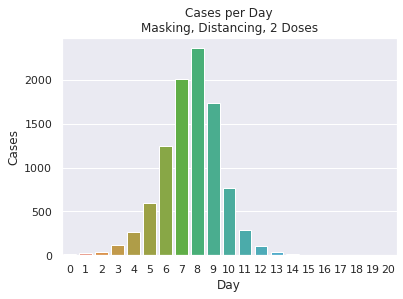

In [ ]:
bar_plot(days, "Day", cases, "Cases", "Cases per Day\nMasking, Distancing, 2 Doses", "cases_per_day_mask_dist_two.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

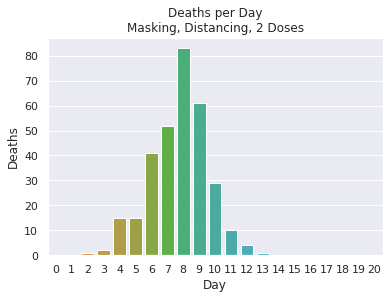

In [ ]:
bar_plot(days, "Day", deaths, "Deaths", "Deaths per Day\nMasking, Distancing, 2 Doses", "deaths_per_day_mask_dist_two.png")

In [ ]:
# One Dose Strategy
days, cases, recovered, deaths = simulate_pandemic(50,10,0.01,1,1,1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

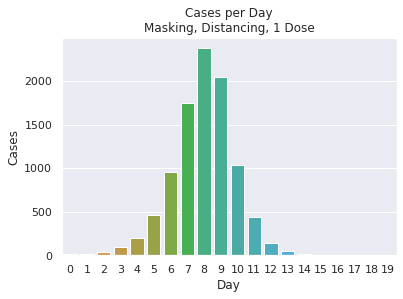

In [ ]:
bar_plot(days, "Day", cases, "Cases", "Cases per Day\nMasking, Distancing, 1 Dose", "cases_per_day_mask_dist_one.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

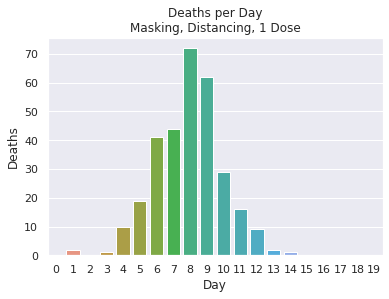

In [ ]:
bar_plot(days, "Day", deaths, "Deaths", "Deaths per Day\nMasking, Distancing, 1 Dose", "deaths_per_day_mask_dist_one.png")

In [ ]:
# Two Dose Strategy with Lockdown
days, cases, recovered, deaths = simulate_pandemic(50,10,0.01,1,2,0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

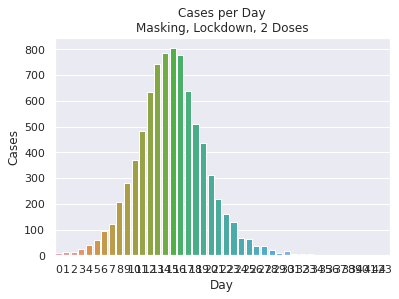

In [ ]:
bar_plot(days, "Day", cases, "Cases", "Cases per Day\nMasking, Lockdown, 2 Doses", "cases_per_day_lockdown.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

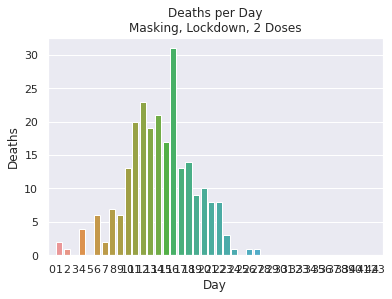

In [ ]:
bar_plot(days, "Day", deaths, "Deaths", "Deaths per Day\nMasking, Lockdown, 2 Doses", "deaths_per_day_lockdown.png")

In [ ]:
# Herd Immunity Strategy
days, cases, recovered, deaths = simulate_pandemic(50,10,0.01,0,0,1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

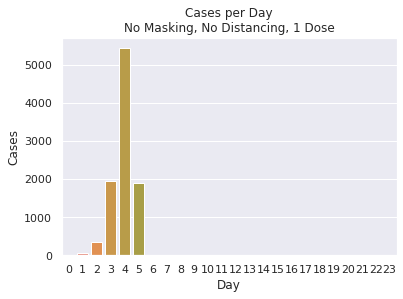

In [ ]:
bar_plot(days, "Day", cases, "Cases", "Cases per Day\nNo Masking, No Distancing, 1 Dose", "cases_per_day_herd_immunity.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

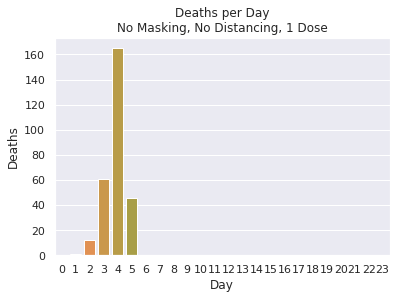

In [ ]:
bar_plot(days, "Day", deaths, "Deaths", "Deaths per Day\nNo Masking, No Distancing, 1 Dose", "deaths_per_day_herd_immunity.png")